In [1]:
from icrl import *

d:\Anaconda3\envs\textgen\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bin d:\Anaconda3\envs\textgen\lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


## Setup 1

In [7]:
num_actions = 10
conext_dim = 5
env = Environment(num_actions, conext_dim)

# LinUCB
linucb = LinUCB(num_actions, conext_dim)

T = 200
num_trajectories = 10000

100,000 trajactories, 200 time steps each

In [10]:
import tqdm
trajectories = [] # Store all trajectories
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar

for i in tqdm.tqdm(range(num_trajectories)):

    total_regret = 0
    regrets = []
    best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
    best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
    states, actions, rewards, action_indexs = [], [], [], []
    
    for _ in range(T):
        action_index = linucb.select_action(env.action_set)
        reward, action = env.step(action_index)
        # find action
        linucb.update(reward, action)
        # Calculate regret for this round and add to total
        expected_reward = np.dot(env.action_set[action_index], env.w_star)
        
        round_regret = best_action_reward - expected_reward
        total_regret += round_regret
        # print(round_regret)
        # Store state, action, reward for this round
        states.append(env.get_action_set()) 
        actions.append(action)
        rewards.append(reward)
        action_indexs.append(action_index)
        regrets.append(total_regret)

    all_regrets[i] = regrets # Store regrets for this trajectory
    trajectories.append((states, actions, rewards, action_indexs)) # Store trajectory
    # Reset env and LinUCB for next trajectory
    env.reset()
    linucb.reset()

100%|██████████| 10000/10000 [06:12<00:00, 26.88it/s]


In [12]:
# Use dataframes to store the data
import pandas as pd
df_regrets= pd.DataFrame(all_regrets)
df_regrets.to_csv('data/linucb_regrets.csv', index=False)


# Save trajectories
import pickle
with open('data/linucb_trajectories.pkl', 'wb') as f:
    pickle.dump(trajectories, f)

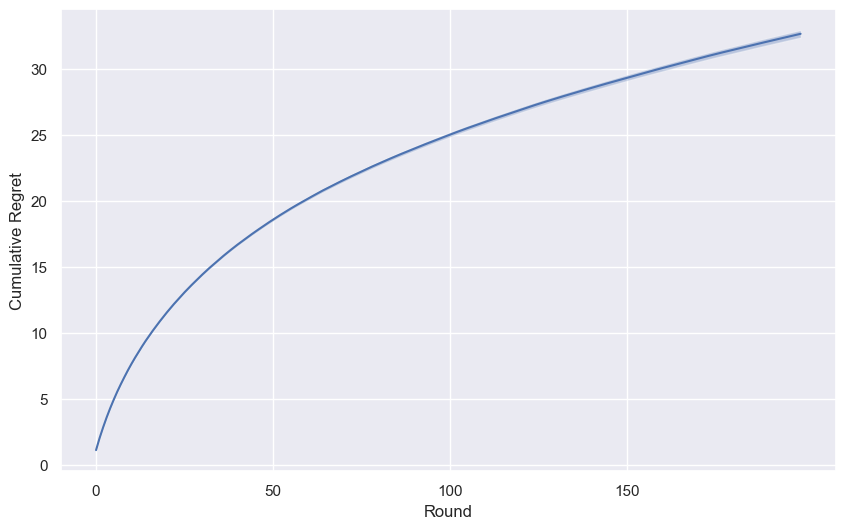

In [13]:
# Plot the average regret with confidence interval
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# load data
df_regrets = pd.read_csv('data/linucb_regrets.csv')

sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_regrets.mean(), label='LinUCB')
plt.fill_between(df_regrets.columns, df_regrets.mean() - df_regrets.std()/np.sqrt(num_trajectories), df_regrets.mean() + df_regrets.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')
plt.savefig('linucb_regret.png')
plt.show()


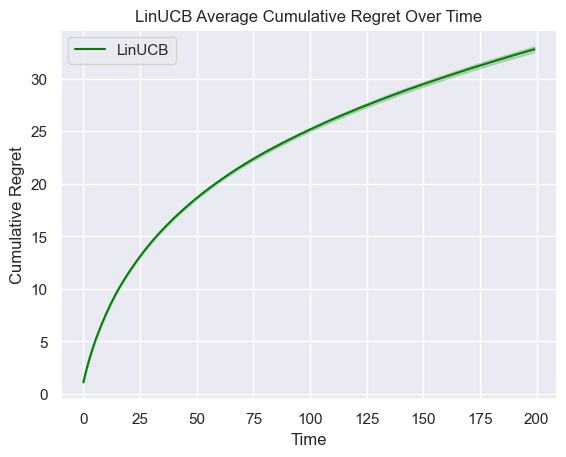

In [11]:
# 计算每一步的平均累计遗憾和标准差
average_regrets = df_regrets.mean(axis=0)
std_regrets = df_regrets.std(axis=0)/np.sqrt(num_trajectories)

# 时间点
time_steps = np.arange(200)

# 绘制平均累计遗憾
plt.plot(time_steps, average_regrets, label='LinUCB', color='green')

# 绘制标准差阴影区域
plt.fill_between(time_steps, average_regrets - std_regrets, average_regrets + std_regrets, color='green', alpha=0.2)

# 设置图表标签和标题
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('LinUCB Average Cumulative Regret Over Time')
plt.legend()
plt.show()

# Thompson Sampling

In [19]:
num_actions = 10
conext_dim = 5

env = Environment(num_actions, conext_dim)
# Thompson Sampling
thompson = ThompsonSampling(num_actions, conext_dim)

In [20]:
import tqdm
T = 200
num_trajectories = 10000

trajectories = [] # Store all trajectories
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar

for i in tqdm.tqdm(range(num_trajectories)):

    total_regret = 0
    regrets = []
    best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
    best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
    states, actions, rewards, action_indexs = [], [], [], []

    for _ in range(T):
        action_index = thompson.select_action(env.action_set)
        reward, action = env.step(action_index)
        # find action
        thompson.update(reward, action)
        # Calculate regret for this round and add to total
        expected_reward = np.dot(env.action_set[action_index], env.w_star)
        
        round_regret = best_action_reward - expected_reward
        # print(round_regret)
        total_regret += round_regret

        # Store state, action, reward for this round
        states.append(env.get_action_set()) 
        actions.append(action)
        rewards.append(reward)
        action_indexs.append(action_index)
        regrets.append(total_regret)

    all_regrets[i] = regrets # Store regrets for this trajectory
    trajectories.append((states, actions, rewards, action_indexs)) # Store trajectory
    # Reset env and LinUCB for next trajectory
    env.reset()
    thompson.reset()

 15%|█▌        | 1501/10000 [01:02<05:55, 23.88it/s]


KeyboardInterrupt: 

In [ ]:
# Use dataframes to store the data
import pandas as pd
df_regrets= pd.DataFrame(all_regrets)
df_regrets.to_csv('Thompson_regrets.csv', index=False)


# Save trajectories
import pickle
with open('Thompson_trajectories.pkl', 'wb') as f:
    pickle.dump(trajectories, f)

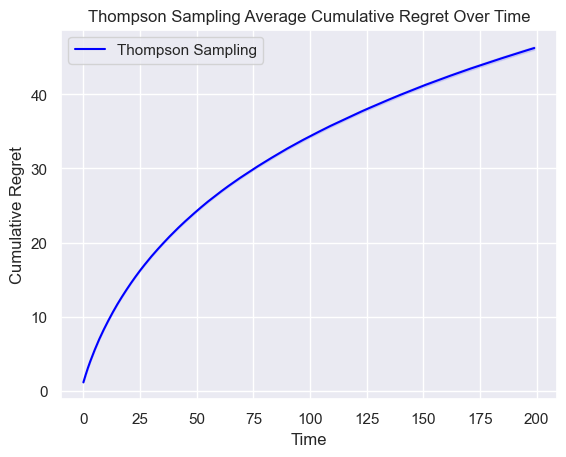

In [23]:
# 计算每一步的平均累计遗憾和标准差
df_regrets = pd.read_csv('Thompson_regrets.csv')

average_regrets = df_regrets.mean(axis=0)
std_regrets = df_regrets.std(axis=0)/np.sqrt(num_trajectories)

# 时间点
time_steps = np.arange(200)

# 绘制平均累计遗憾
plt.plot(time_steps, average_regrets, label='Thompson Sampling', color='blue')

# 绘制标准差阴影区域
plt.fill_between(time_steps, average_regrets - std_regrets, average_regrets + std_regrets, color='blue', alpha=0.1)

# 设置图表标签和标题
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Thompson Sampling Average Cumulative Regret Over Time')
plt.legend()
plt.show()

# Pretrain Transformers

In [2]:
from icrl import *
from model import *

num_actions = 10
context_dim = 5
env = Environment(num_actions, context_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load model
model = TransformerModel(embed_dim=70, num_heads=5)

d:\Anaconda3\envs\textgen\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bin d:\Anaconda3\envs\textgen\lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


NameError: name 'TransformerModel' is not defined

In [ ]:
batchsize = 64

In [11]:
# load model from file
import tqdm 
config = {
        'horizon': 200,
        'dim':5,
        'act_num':10,
        'state_dim': 50,
        'action_dim': 10,
        'n_layer': 8,
        'n_embd': 32,
        'n_head': 4,
        'shuffle': True,
        'dropout': 0,
        'test': True,
        'act_type': 'relu',
    }
num_actions = 10
context_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T = 200


model = Transformer(config)
model.load_state_dict(torch.load('model/transformer_model.pth'))
model.to(device)
model.eval()  # 确保模型在评估模式
# evaluate the model
num_trajectories = 10000

batchsize = 32

trajectories = [] # Store all trajectories
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar
# for i in tqdm.tqdm(range(num_trajectories)):
for i in tqdm.tqdm(range(num_trajectories//batchsize)):

    envs = [Environment(num_actions, context_dim) for _ in range(batchsize)]
    total_regret = np.zeros(batchsize)
    # regrets = np.zeros((batchsize, T))
    regrets = [[] for _ in range(batchsize)]

    best_action_indexs = [env.get_best_action_index() for env in envs]  # Best action doesn't change in this setup
    best_action_rewards = [np.dot(env.action_set[best_action_index], env.w_star) for env, best_action_index in zip(envs, best_action_indexs)]
    states, actions, rewards, action_indexs = [[] for _ in range(batchsize)], [[] for _ in range(batchsize)], [[] for _ in range(batchsize)], [[] for _ in range(batchsize)]
    action_sets = [torch.tensor(env.get_action_set(), dtype=torch.float32).to(device).reshape(-1) for env in envs]
    # action_sets shape: [batchsize, num_actions*context_dim]
    action_sets = torch.stack(action_sets).reshape(batchsize, -1) # [batchsize, num_actions*context_dim]
    # print(action_sets.shape)
    # embeddings = [[] for _ in range(batchsize)]
    # embeddings = torch.zeros((batchsize, T, 70), dtype=torch.float32).to(device)
    # # regrets = []
    # best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
    # best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
    # states, actions, rewards, action_indexs = [], [], [], []

    # embeddings = []
    for t in range(1, T+1):
        if t == 1:
            context_actions = torch.empty((batchsize, 0, num_actions), dtype=torch.float32).to(device)
            context_rewards = torch.empty((batchsize, 0, 1), dtype=torch.float32).to(device)
            x = {
                'action_set': action_sets,
                'context_actions': context_actions,
                'context_rewards': context_rewards
            }
        else:
            x = {
                'action_set': action_sets,
                'context_actions': context_actions,
                'context_rewards': context_rewards
            }
        last_timestep_outputs = model(x) 
        # last_timestep_outputs shape: [batchsize, num_actions]
        action_indices = torch.multinomial(F.softmax(last_timestep_outputs, dim=-1), 1) #dimension [batchsize, 1]

        # choose 2t-1 the last one
        # print(action_indices.shape)
        # action_indices = action_index[:][-1].argmax().item()
        # print(action_index)
        # [2*t-1].argmax().item()

        rewards_ = [env.step(action_index)[0] for env, action_index in zip(envs, action_indices)]
        actions_ = [env.step(action_index)[1] for env, action_index in zip(envs, action_indices)]
        # print(len(actions_))
        # find action
        actions_one_hot = torch.zeros(batchsize, 1, num_actions).to(device)
        actions_one_hot.scatter_(2, action_indices.unsqueeze(1), 1)

        reward_tensor = torch.tensor(rewards_, dtype=torch.float32).to(device).reshape(batchsize, 1, 1)
        
        context_actions = torch.cat([context_actions, actions_one_hot], dim=1)
        context_rewards = torch.cat([context_rewards, reward_tensor], dim=1)

        
        expected_rewards = [np.dot(env.action_set[action_index], env.w_star) for env, action_index in zip(envs, action_indices)]
        
        # round_regret = best_action_reward - expected_reward
        round_regrets = [best_action_reward - expected_reward for best_action_reward, expected_reward in zip(best_action_rewards, expected_rewards)]
        # print(round_regret)
        # total_regret += round_regret
        total_regret += round_regrets

        # Store state, action, reward for this round
        # states.append(env.get_action_set()) 
        # actions.append(action)
        # rewards.append(reward)
        # action_indexs.append(action_index)
        # regrets.append(total_regret)
        for j in range(batchsize):
            regrets[j].append(total_regret[j])
            states[j].append(envs[j].get_action_set())
            actions[j].append(actions_[j])
            rewards[j].append(rewards_[j])
            action_indexs[j].append(action_indices[j].item())

    # all_regrets[i] = regrets # Store regrets for this trajectory
    all_regrets[i*batchsize:(i+1)*batchsize] = regrets
    trajectories.append((states, actions, rewards, action_indexs)) # Store trajectory
    # Reset env and LinUCB for next trajectory
    # for env in envs:
    #     env.reset()


 15%|█▌        | 48/312 [04:30<26:04,  5.92s/it]

In [8]:
# save the regrets
import pandas as pd
df_regrets = pd.DataFrame(all_regrets)
df_regrets.to_csv('data/transformer_regrets.csv', index=False)

(1000, 200)


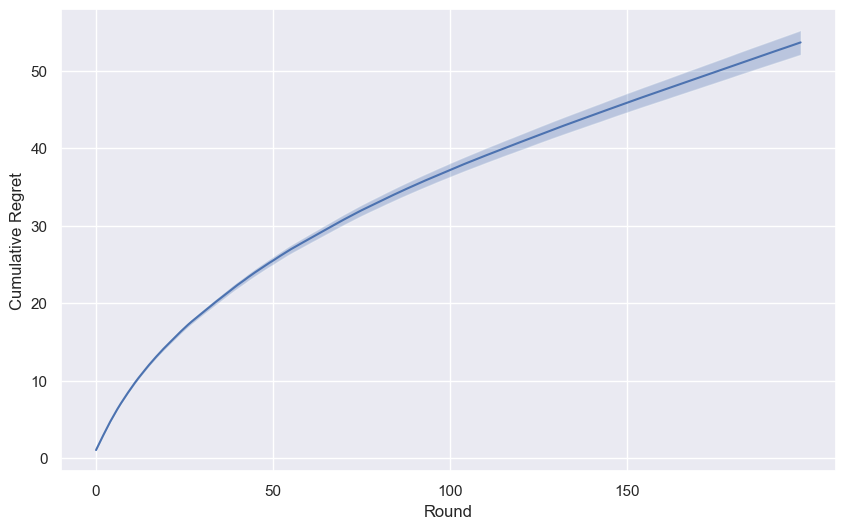

In [9]:

# plot the average regret with confidence interval
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# load data
df_regrets = pd.read_csv('data/transformer_regrets.csv')
print(df_regrets.shape)
sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_regrets.mean(), label='Transformer')
plt.fill_between(df_regrets.columns, df_regrets.mean() - df_regrets.std()/np.sqrt(num_trajectories), df_regrets.mean() + df_regrets.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')
plt.savefig('transformer_regret.png')

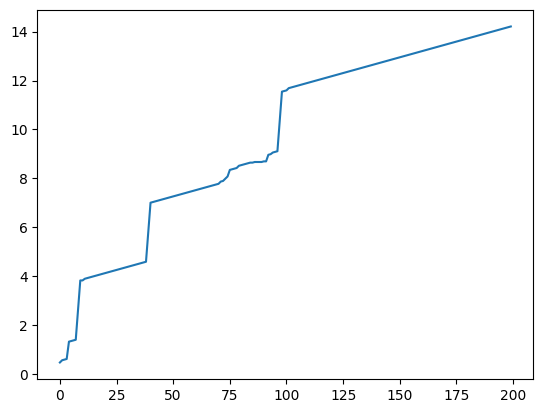

In [23]:
# eval the transformer model
from icrl import *
from model import *
config = {
        'horizon': 200,
        'dim':5,
        'act_num':10,
        'state_dim': 50,
        'action_dim': 10,
        'n_layer': 8,
        'n_embd': 32,
        'n_head': 4,
        'shuffle': True,
        'dropout': 0,
        'test': True,
        'act_type': 'relu',

    }
num_actions = 10
context_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T = 200


model = Transformer(config)
model.load_state_dict(torch.load('model/transformer_model.pth'))
model.to(device)
model.eval()  # 确保模型在评估模式

env = Environment(num_actions, context_dim)
best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
# evaluate the model
total_regrets = np.zeros(T)
total_regret = 0
action_set = env.get_action_set()
action_set = torch.tensor(action_set, dtype=torch.float32).to(device).reshape(-1)
action_indices = []
rewards = []

for t in range(1, T+1):
    if t == 1:
        context_actions = torch.empty(0, num_actions).to(device).unsqueeze(0) # batch_size, 0, num_actions
        context_rewards = torch.empty(0, 1).to(device).unsqueeze(0) # batch_size, 0, 1
        x = {
            'action_set': action_set.unsqueeze(0),
            'context_actions': context_actions,
            'context_rewards': context_rewards
        }
    else:
        x = {
            'action_set': action_set.unsqueeze(0),
            'context_actions': context_actions,
            'context_rewards': context_rewards
        }
        # action_indices = model(x)

    last_timestep_outputs = model(x)
    # last_timestep_outputs = model_outputs[:, -1, :]

    # 找到最后一个时间步中每个动作得分最高的索引
    # action_indices = last_timestep_outputs.argmax(dim=1)
    # 找到最后一个时间步，用softmax算出每个动作的概率，并按照概率随机选择动作
    action_indices = torch.multinomial(torch.softmax(last_timestep_outputs, dim=1), 1)
    
    # print(action_indices)
    # choose 2t-1 the last one
    # print(action_indices.shape)
    # action_indices = action_index[:][-1].argmax().item()
    # print(action_index)
    # [2*t-1].argmax().item()

    rewards_ = env.step(action_indices[0].item())[0]
    actions_ = env.step(action_indices[0].item())[1]
    # 转化成一个one-hot向量
    actions_one_hot = torch.zeros(1, 1, num_actions).to(device) # batch_size, 1, num_actions
    # print(action_indices.shape)
    # print(actions_one_hot.shape)
    actions_one_hot.scatter_(2, action_indices.unsqueeze(0), 1) # batch_size, num_actions

    reward_tensor = torch.tensor(rewards_, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(0).unsqueeze(0) # batch_size, 1, 1
    # print(reward_tensor.shape)
    context_actions = torch.cat((context_actions, actions_one_hot), dim=1)
    context_rewards = torch.cat((context_rewards, reward_tensor), dim=1)
    
    # embeddings_even = TrajectoryDataset.embed_even(actions_, rewards_, t-1, context_dim, num_actions)
    # embeddings.append(embeddings_even)
    # Calculate regret for this round and add to total
    expected_reward = np.dot(env.action_set[action_indices[0].item()], env.w_star)
    # print(expected_reward)
    round_regret = best_action_reward - expected_reward
    total_regret += round_regret
    # print(round_regret)
    total_regrets[t-1] = total_regret
    # print(rewards_, actions_)
# 画出total regret，横轴是时间，纵轴是累计遗憾
plt.plot(total_regrets)


# Integration

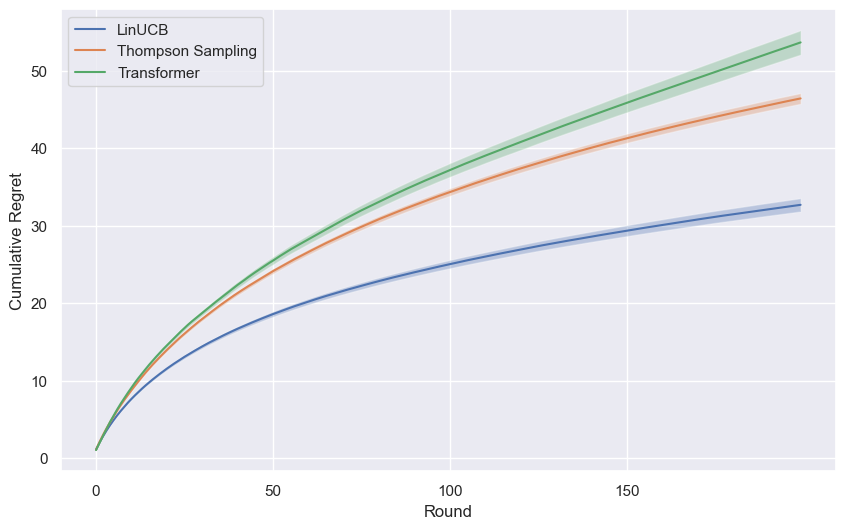

In [10]:
#linucb, thompson, transformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load data
df_linucb = pd.read_csv('data/linucb_regrets.csv')
df_thompson = pd.read_csv('data/Thompson_regrets.csv')
df_transformer = pd.read_csv('data/transformer_regrets.csv')

# plot the average regret with confidence interval
sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_linucb.mean(), label='LinUCB')
plt.fill_between(df_linucb.columns, df_linucb.mean() - df_linucb.std()/np.sqrt(num_trajectories), df_linucb.mean() + df_linucb.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.plot(df_thompson.mean(), label='Thompson Sampling')
plt.fill_between(df_thompson.columns, df_thompson.mean() - df_thompson.std()/np.sqrt(num_trajectories), df_thompson.mean() + df_thompson.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.plot(df_transformer.mean(), label='Transformer')
plt.fill_between(df_transformer.columns, df_transformer.mean() - df_transformer.std()/np.sqrt(num_trajectories), df_transformer.mean() + df_transformer.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')
plt.legend()
plt.savefig('all_regret.png')
